In [5]:
from pymeos.db.psycopg import MobilityDB
from pymeos import *
from datetime import datetime, timedelta
import time
from collections import deque
from pympler import asizeof
import gc
from enum import Enum
import numpy as np
from shapely.geometry import Point
import math
import subprocess
import shutil
import os
import sys

DIRECTORY_PATH = os.getcwd()
MATRIX_DIRECTORY_PATH = f'{DIRECTORY_PATH}/matrices'

# AIS Danish maritime dataset
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "processed_data"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "traj"


class Database_connector:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME                  
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        )
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str})
                        AND a.{self.tpoint_column_name} IS NOT NULL;
                    """
            self.cursor.execute(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            self.log(e)


    def get_min_timestamp(self):
        """
        Returns the min timestamp of the tpoints columns.

        """
        try:
            
            self.cursor.execute(f"SELECT MIN(startTimestamp({self.tpoint_column_name})) AS earliest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass

    def get_max_timestamp(self):
        """
        Returns the max timestamp of the tpoints columns.

        """
        try:
            self.cursor.execute(f"SELECT MAX(endTimestamp({self.tpoint_column_name})) AS latest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()




FPS_DEQUEUE_SIZE = 5 # Length of the dequeue to calculate the average FPS
TIME_DELTA_DEQUEUE_SIZE =  10 # Length of the dequeue to keep the keys to keep in the buffer


PERCENTAGE_OF_OBJECTS = 1 # To not overload the memory, we only take a percentage of the ships in the database
TIME_DELTA_SIZE = 240 # Number of frames associated to one Time delta
GRANULARITY = timedelta(minutes=1) # Time delta between two frames
SRID = 4326
FPS = 60



  

In [6]:
db = Database_connector()

start_date = db.get_min_timestamp()
end_date = db.get_max_timestamp()
total_frames = math.ceil( (end_date - start_date) // GRANULARITY )

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]

In [7]:
timestamps.index(datetime.strptime('2023-06-01 03:00:00', '%Y-%m-%d %H:%M:%S'))

180

In [8]:
x_min = -180
y_min = -90
x_max = 180
y_max = 90

start_frame= 0
end_frame = 479

arguments = [start_frame, end_frame, PERCENTAGE_OF_OBJECTS, x_min, y_min, x_max, y_max]
arguments = [str(arg) for arg in arguments]
arguments += [timestamps_strings[0]  , str(len(timestamps)), "MINUTE", MATRIX_DIRECTORY_PATH, DATABASE_NAME, TPOINT_TABLE_NAME, TPOINT_ID_COLUMN_NAME, TPOINT_COLUMN_NAME]
            

In [9]:
arguments

['0',
 '479',
 '1',
 '-180',
 '-90',
 '180',
 '90',
 '2023-06-01 00:00:00',
 '1439',
 'MINUTE',
 '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/matrices',
 'mobilitydb',
 'processed_data',
 'MMSI',
 'traj']

In [6]:
# Command to execute Program B
command = ['/usr/bin/python3', '/home/ali/QGIS-MobilityDB/experiment8_subprocess/matrix_file_processed.py', *arguments]
result = subprocess.run(command, capture_output=True, text=True)

In [7]:
result

CompletedProcess(args=['/usr/bin/python3', '/home/ali/QGIS-MobilityDB/experiment8_subprocess/matrix_file_processed.py', '240', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '1439', 'MINUTE', '/home/ali/QGIS-MobilityDB/experiment8_subprocess/matrices', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 23.64022731781006 seconds, 709.2068195343018 frames for 30 fps animation.\n', stderr='')

import numpy as np

# Load the .npy file with allow_pickle set to True
loaded_matrix = np.load('matrix_0.npy', allow_pickle=True)

print(loaded_matrix)


# Debugging process B code

In [10]:
sysargs =arguments 
sysargs

['0',
 '479',
 '1',
 '-180',
 '-90',
 '180',
 '90',
 '2023-06-01 00:00:00',
 '1439',
 'MINUTE',
 '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/matrices',
 'mobilitydb',
 'processed_data',
 'MMSI',
 'traj']

In [7]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time

logs = ""
now = time.time()

FPS_DEQUEUE_SIZE = 5 # Length of the dequeue to calculate the average FPS
TIME_DELTA_DEQUEUE_SIZE =  10 # Length of the dequeue to keep the keys to keep in the buffer


args = sysargs
logs += f"Args: {args}\n"
begin_frame = int(args[0])
end_frame = int(args[1])
TIME_DELTA_SIZE = end_frame - begin_frame + 1
PERCENTAGE_OF_OBJECTS = float(args[2])


SRID = 4326


DATABASE_NAME = args[11]
TPOINT_TABLE_NAME = args[12]
TPOINT_ID_COLUMN_NAME = args[13]
TPOINT_COLUMN_NAME = args[14]



class Database_connector:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME               
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        )
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str});
                    """
            self.cursor.execute(query)
            # print(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            # print(e)
            pass


    def get_min_timestamp(self):
        """
        Returns the min timestamp of the tpoints columns.

        """
        try:
            
            self.cursor.execute(f"SELECT MIN(startTimestamp({self.tpoint_column_name})) AS earliest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass

    def get_max_timestamp(self):
        """
        Returns the max timestamp of the tpoints columns.

        """
        try:
            self.cursor.execute(f"SELECT MAX(endTimestamp({self.tpoint_column_name})) AS latest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()


MATRIX_DIRECTORY_PATH = "/home/ali/matrices"
file_name = f"/home/ali/matrices/matrix_{begin_frame}.npy"


  
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }


# check if file does't already exist

pymeos_initialize()
db = Database_connector()

x_min = float(args[3])
y_min = float(args[4])
x_max = float(args[5])
y_max = float(args[6])

start_date = args[7]
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')


total_frames = int(args[8])
GRANULARITY = Time_granularities[args[9]]

timestamps = []
for i in range(total_frames): 
    timestamps.append(start_date + i*GRANULARITY)



p_start = timestamps[begin_frame]
p_end = timestamps[end_frame]
# print(p_start, p_end, x_min, y_min, x_max, y_max)
now_db = time.time()
rows = db.get_subset_of_tpoints(p_start, p_end, x_min, y_min, x_max, y_max)    

print(f"Time to fetch tpoints : {time.time() - now_db} s")    
        

Time to fetch tpoints : 1.7701716423034668 s


In [8]:

empty_point_wkt = Point() # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

time_ranges = timestamps
now = time.time()

for i in range(len(rows)):
    if rows[i][0] is not None:
        try:
            traj = rows[i][0]
            num_instants = traj.num_instants()
            if num_instants == 1:
                single_timestamp = traj.timestamps()[0].replace(tzinfo=None).replace(second=0, microsecond=0)
                index = time_ranges.index(single_timestamp) - begin_frame
                matrix[i][index] = traj.values()[0]
            
            elif num_instants >= 2:
                traj_resampled = traj.temporal_sample(start=time_ranges[0],duration= GRANULARITY)
                
                start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
                end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
        
                trajectory_array = np.array([point for point in traj_resampled.values()])
                matrix[i, start_index:end_index+1] = trajectory_array
    
        except:
            continue


db.close()
# pymeos_finalize()
total_time = time.time() - now
frames_for_30_fps= 30 * total_time
print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
# logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"


Matrix 0 created in 15.315945386886597 seconds, 459.4783616065979 frames for 30 fps animation.


In [13]:
np.count_nonzero(matrix != 'POINT EMPTY')

865793

# With resample in the database query

In [7]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time

logs = ""
now = time.time()

FPS_DEQUEUE_SIZE = 5 # Length of the dequeue to calculate the average FPS
TIME_DELTA_DEQUEUE_SIZE =  10 # Length of the dequeue to keep the keys to keep in the buffer


args = sysargs
logs += f"Args: {args}\n"
begin_frame = int(args[0])
end_frame = int(args[1])
TIME_DELTA_SIZE = end_frame - begin_frame + 1
PERCENTAGE_OF_OBJECTS = float(args[2])


SRID = 4326


DATABASE_NAME = args[11]
TPOINT_TABLE_NAME = args[12]
TPOINT_ID_COLUMN_NAME = args[13]
TPOINT_COLUMN_NAME = args[14]



class Database_connector2:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME               
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    WITH trajectories as (
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        ) as trajectory
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str}))

                    SELECT tsample(trajectory, INTERVAL '1 minute', TIMESTAMP '2023-06-01 00:00:00')  AS resampled_trajectory
                        FROM 
                            trajectories ;
 
                    """
            self.cursor.execute(query)
            # print(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            # print(e)
            pass


    def get_min_timestamp(self):
        """
        Returns the min timestamp of the tpoints columns.

        """
        try:
            
            self.cursor.execute(f"SELECT MIN(startTimestamp({self.tpoint_column_name})) AS earliest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass

    def get_max_timestamp(self):
        """
        Returns the max timestamp of the tpoints columns.

        """
        try:
            self.cursor.execute(f"SELECT MAX(endTimestamp({self.tpoint_column_name})) AS latest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()


MATRIX_DIRECTORY_PATH = "/home/ali/matrices"
file_name = f"/home/ali/matrices/matrix_{begin_frame}.npy"


  
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }


# check if file does't already exist

pymeos_initialize()
db = Database_connector2()

x_min = float(args[3])
y_min = float(args[4])
x_max = float(args[5])
y_max = float(args[6])

start_date = args[7]
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')


total_frames = int(args[8])
GRANULARITY = Time_granularities[args[9]]

timestamps = []
for i in range(total_frames): 
    timestamps.append(start_date + i*GRANULARITY)



p_start = timestamps[begin_frame]
p_end = timestamps[end_frame]
# print(p_start, p_end, x_min, y_min, x_max, y_max)
now_db = time.time()
rows = db.get_subset_of_tpoints(p_start, p_end, x_min, y_min, x_max, y_max)    

print(f"Time to fetch tpoints : {time.time() - now_db} s")    
        

Time to fetch tpoints : 1.8734567165374756 s


In [15]:
empty_point_wkt = Point()  # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

time_ranges = timestamps
now = time.time()

# try:
for i in range(len(rows)):
    if rows[i][0] is not None:
        try:
            traj_resampled = rows[i][0]

            start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            matrix[i, start_index:end_index+1] = np.array(traj_resampled.values())
    
        except:
            print(i)
            # continue


# db.close()
# pymeos_finalize()
total_time = time.time() - now
frames_for_30_fps= 30 * total_time
print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
# logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"


Matrix 0 created in 15.015557765960693 seconds, 450.4667329788208 frames for 30 fps animation.


In [32]:
np.count_nonzero(matrix != 'POINT EMPTY')

2794080

In [26]:
%load_ext line_profiler

In [29]:
def opr(rows):
    empty_point_wkt = Point()  # "POINT EMPTY"
    matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

    time_ranges = timestamps
    now = time.time()

    for i in range(len(rows)):
        if rows[i][0] is not None:
            try:
                traj_resampled = rows[i][0]
                # num_instants = traj_resampled.num_instants()
                # if num_instants == 1:
                #     # print(f"{i} has one instant")
                #     single_timestamp = traj_resampled.timestamps()[0].replace(tzinfo=None).replace(second=0, microsecond=0)
                #     index = time_ranges.index(single_timestamp) - begin_frame
                #     matrix[i][index] = traj.values()[0].wkt
                
                # elif num_instants >= 2:
                    # traj_resampled = traj.temporal_sample(start=time_ranges[0],duration= GRANULARITY)
                    
                start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
                end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
                vals = traj_resampled.values()
                trajectory_array = np.array(vals)
                matrix[i, start_index:end_index+1] = trajectory_array
        
            except:
                continue


    # db.close()
    # pymeos_finalize()
    total_time = time.time() - now
    frames_for_30_fps= 30 * total_time
    print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
    # logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"

    

In [30]:
%lprun -f opr opr(rows)

Matrix 0 created in 25.74210810661316 seconds, 772.2632431983948 frames for 30 fps animation.


Timer unit: 1e-09 s

Total time: 25.1043 s
File: /tmp/ipykernel_5042/310096134.py
Function: opr at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def opr(rows):
     2         1      54306.0  54306.0      0.0      empty_point_wkt = Point()  # "POINT EMPTY"
     3         1    6041035.0    6e+06      0.0      matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)
     4                                           
     5         1        392.0    392.0      0.0      time_ranges = timestamps
     6         1        716.0    716.0      0.0      now = time.time()
     7                                           
     8      5822    1132901.0    194.6      0.0      for i in range(len(rows)):
     9      5821    1072371.0    184.2      0.0          if rows[i][0] is not None:
    10      4174     365683.0     87.6      0.0              try:
    11      4174     670280.0    160.6      0.0             

In [22]:
now = time.time()

for i in range(len(rows)):
    if rows[i][0] is not None:
        try:
            traj_resampled = rows[i][0]

            start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            vals = traj_resampled.values()
            trajectory_array = np.array([point.wkt for point in vals])
            matrix[i, start_index:end_index+1] = trajectory_array

        except:
            continue
        
print(f" Time to fill the matrix : {time.time() - now} s")

 Time to fill the matrix : 19.8060622215271 s


In [24]:
x1 = TGeomPointInst(point=(0, 0), timestamp=timestamps[0])
x2 = TGeomPointInst(point=(1, 1), timestamp=timestamps[TIME_DELTA_SIZE-1])
traj = TGeomPointSeq.from_instants([x1, x2], upper_inc=True)
traj_resampled = traj.temporal_sample(start=timestamps[0],duration= GRANULARITY)
empty_point_wkt = Point().wkt  # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)
trajectory_array = np.array([point.wkt for point in traj_resampled.values()])
trajectory_array

now = time.time()

for i in range(len(rows)):
    if 1 == 1 :
        try:
            start_index = timestamps.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) 
            end_index = timestamps.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) 

            trajectory_array = np.array([point.wkt for point in traj_resampled.values()])
            matrix[i, start_index:end_index+1] = trajectory_array
        except:
            continue
print(f"Time to fill the matrix : {time.time() - now} s")

Time to fill the matrix : 23.57325553894043 s


In [28]:
%lprun -f opr opr(rows)

Matrix 0 created in 34.37529969215393 seconds, 1031.258990764618 frames for 30 fps animation.


Timer unit: 1e-09 s

Total time: 33.4186 s
File: /tmp/ipykernel_5042/2884772419.py
Function: opr at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def opr(rows):
     2         1      68870.0  68870.0      0.0      empty_point_wkt = Point()  # "POINT EMPTY"
     3         1    6289944.0    6e+06      0.0      matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)
     4                                           
     5         1        410.0    410.0      0.0      time_ranges = timestamps
     6         1        889.0    889.0      0.0      now = time.time()
     7                                           
     8      5822    1172389.0    201.4      0.0      for i in range(len(rows)):
     9      5821    1257898.0    216.1      0.0          if rows[i][0] is not None:
    10      4174     417364.0    100.0      0.0              try:
    11      4174     507546.0    121.6      0.0            

In [12]:
pip install line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 8.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
np.count_nonzero(matrix != 'POINT EMPTY')

865790

# With indexing and resampling in database

In [12]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time

logs = ""
now = time.time()

FPS_DEQUEUE_SIZE = 5 # Length of the dequeue to calculate the average FPS
TIME_DELTA_DEQUEUE_SIZE =  10 # Length of the dequeue to keep the keys to keep in the buffer


args = sysargs
logs += f"Args: {args}\n"
begin_frame = int(args[0])
end_frame = int(args[1])
TIME_DELTA_SIZE = end_frame - begin_frame + 1
PERCENTAGE_OF_OBJECTS = float(args[2])


SRID = 4326


DATABASE_NAME = args[11]
TPOINT_TABLE_NAME = args[12]
TPOINT_ID_COLUMN_NAME = args[13]
TPOINT_COLUMN_NAME = args[14]



class Database_connector3:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME               
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    WITH trajectories as (
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        ) as trajectory
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str})),

                    resampled as (

                    SELECT tsample(traj.trajectory, INTERVAL '1 minute', TIMESTAMP '2023-06-01 00:00:00')  AS resampled_trajectory
                        FROM 
                            trajectories as traj)
				
                    SELECT
                            EXTRACT(EPOCH FROM (startTimestamp(rs.resampled_trajectory) - '2023-06-01 00:00:00'::timestamp))::integer / 60 AS start_index ,
                            EXTRACT(EPOCH FROM (endTimestamp(rs.resampled_trajectory) - '2023-06-01 00:00:00'::timestamp))::integer / 60 AS end_index,
                            rs.resampled_trajectory
                    FROM resampled as rs ;
 
                    """
            self.cursor.execute(query)
            # print(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            # print(e)
            pass


    def get_min_timestamp(self):
        """
        Returns the min timestamp of the tpoints columns.

        """
        try:
            
            self.cursor.execute(f"SELECT MIN(startTimestamp({self.tpoint_column_name})) AS earliest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass

    def get_max_timestamp(self):
        """
        Returns the max timestamp of the tpoints columns.

        """
        try:
            self.cursor.execute(f"SELECT MAX(endTimestamp({self.tpoint_column_name})) AS latest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()


MATRIX_DIRECTORY_PATH = "/home/ali/matrices"
file_name = f"/home/ali/matrices/matrix_{begin_frame}.npy"


  
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }


# check if file does't already exist

pymeos_initialize()
db = Database_connector3()

x_min = float(args[3])
y_min = float(args[4])
x_max = float(args[5])
y_max = float(args[6])

start_date = args[7]
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')


total_frames = int(args[8])
GRANULARITY = Time_granularities[args[9]]

timestamps = []
for i in range(total_frames): 
    timestamps.append(start_date + i*GRANULARITY)



p_start = timestamps[begin_frame]
p_end = timestamps[end_frame]
# print(p_start, p_end, x_min, y_min, x_max, y_max)
now_db = time.time()
rows = db.get_subset_of_tpoints(p_start, p_end, x_min, y_min, x_max, y_max)    

print(f"Time to fetch tpoints : {time.time() - now_db} s")    
        

Time to fetch tpoints : 2.397526502609253 s


In [14]:
empty_point_wkt = Point()  # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

time_ranges = timestamps
now = time.time()

# try:
for i in range(len(rows)):
    if rows[i][2] is not None:
        try:
            traj_resampled = rows[i][2]

            start_index = rows[i][0] 
            end_index = rows[i][1]
            matrix[i, start_index:end_index+1] = np.array(traj_resampled.values())
    
        except:
            print(i)
            # continue


# db.close()
# pymeos_finalize()
total_time = time.time() - now
frames_for_30_fps= 30 * total_time
print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
# logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"


Matrix 0 created in 13.855250358581543 seconds, 415.6575107574463 frames for 30 fps animation.


In [15]:
np.count_nonzero(matrix != 'POINT EMPTY')

2794080

# Measuring nditer vs for loop for feature generation

In [29]:
%%timeit

empty_point_wkt = Point().wkt  # "POINT EMPTY"
# create a numpy array of size len(ids_list) with empty_point_wkt
starting_points = np.full((1, 5821), empty_point_wkt, dtype=object)

qgis_fields_list = []

for wkt in np.nditer(starting_points, flags=['refs_ok']):
    feat = ["vlayer_fields"]
    feat.append("datetime_obj")  # Set its attributes
    # Create geometry from WKT string
    feat.append(wkt.item())
    qgis_fields_list.append(feat)
        

962 µs ± 39.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%%timeit

empty_point_wkt = Point().wkt  # "POINT EMPTY"

qgis_fields_list = []

for i in range(5821):
    feat = ["vlayer_fields"]
    feat.append("datetime_obj")  # Set its attributes
    # Create geometry from WKT string
    feat.append(empty_point_wkt)
    qgis_fields_list.append(feat)

378 µs ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Removing old files

In [62]:
import shutil

# Path to the directory
directory_path = f'/home/ali/matrices/'

shutil.rmtree(directory_path)


In [63]:
# create directory to store the matrices
os.makedirs(directory_path)

In [21]:
sysargs = ['0',
 '479',
 '1',
 '-180',
 '-90',
 '180',
 '90',
 '2023-06-01 00:00:00',
 '1439',
 'MINUTE',
 '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/matrices',
 'mobilitydb',
 'processed_data',
 'MMSI',
 'traj']

sysargs

['0',
 '479',
 '1',
 '-180',
 '-90',
 '180',
 '90',
 '2023-06-01 00:00:00',
 '1439',
 'MINUTE',
 '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/matrices',
 'mobilitydb',
 'processed_data',
 'MMSI',
 'traj']

In [ ]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time

logs = ""
now = time.time()

FPS_DEQUEUE_SIZE = 5 # Length of the dequeue to calculate the average FPS
TIME_DELTA_DEQUEUE_SIZE =  10 # Length of the dequeue to keep the keys to keep in the buffer


args = sysargs
logs += f"Args: {args}\n"
begin_frame = int(args[0])
end_frame = int(args[1])
TIME_DELTA_SIZE = end_frame - begin_frame + 1
PERCENTAGE_OF_OBJECTS = float(args[2])


SRID = 4326


DATABASE_NAME = args[11]
TPOINT_TABLE_NAME = args[12]
TPOINT_ID_COLUMN_NAME = args[13]
TPOINT_COLUMN_NAME = args[14]



class Database_connector:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME               
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        )
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str});
                    """
            self.cursor.execute(query)
            # print(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            # print(e)
            pass


    def get_min_timestamp(self):
        """
        Returns the min timestamp of the tpoints columns.

        """
        try:
            
            self.cursor.execute(f"SELECT MIN(startTimestamp({self.tpoint_column_name})) AS earliest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass

    def get_max_timestamp(self):
        """
        Returns the max timestamp of the tpoints columns.

        """
        try:
            self.cursor.execute(f"SELECT MAX(endTimestamp({self.tpoint_column_name})) AS latest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()


MATRIX_DIRECTORY_PATH = "/home/ali/matrices"
file_name = f"/home/ali/matrices/matrix_{begin_frame}.npy"


  
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }


# check if file does't already exist

pymeos_initialize()
db = Database_connector()

x_min = float(args[3])
y_min = float(args[4])
x_max = float(args[5])
y_max = float(args[6])

start_date = args[7]
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')


total_frames = int(args[8])
GRANULARITY = Time_granularities[args[9]]

timestamps = []
for i in range(total_frames): 
    timestamps.append(start_date + i*GRANULARITY)



p_start = timestamps[begin_frame]
p_end = timestamps[end_frame]
# print(p_start, p_end, x_min, y_min, x_max, y_max)
now_db = time.time()
rows = db.get_subset_of_tpoints(p_start, p_end, x_min, y_min, x_max, y_max)    

print(f"Time to fetch tpoints : {time.time() - now_db} s")    
        
empty_point_wkt = Point() # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

time_ranges = timestamps
now = time.time()

for i in range(len(rows)):
    if rows[i][0] is not None:
        try:
            traj = rows[i][0]
            num_instants = traj.num_instants()
            if num_instants == 1:
                single_timestamp = traj.timestamps()[0].replace(tzinfo=None).replace(second=0, microsecond=0)
                index = time_ranges.index(single_timestamp) - begin_frame
                matrix[i][index] = traj.values()[0]
            
            elif num_instants >= 2:
                traj_resampled = traj.temporal_sample(start=time_ranges[0],duration= GRANULARITY)
                
                start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
                end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
        
                trajectory_array = np.array([point for point in traj_resampled.values()])
                matrix[i, start_index:end_index+1] = trajectory_array
    
        except:
            continue


db.close()
# pymeos_finalize()
total_time = time.time() - now
frames_for_30_fps= 30 * total_time
print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
# logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"


In [65]:
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()

"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90

Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]





Frames = [60, 120, 240, 480, 960, 1920]
Percentages = [0.1, 0.3, 0.5, 0.7, 0.9, 1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta


combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 3*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        begin_frame, end_frame = delta

        p_start = timestamps[begin_frame]
        p_end = timestamps[end_frame]
        # print(p_start, p_end, x_min, y_min, x_max, y_max)

        sysargs = [str(begin_frame),
                    str(end_frame),
                    str(percentage),
                '-180',
                '-90',
                '180',
                '90',
                str(p_start),
                str(total_frames),
                'SECOND',
                dir_name,
                'mobilitydb',
                'processed_data',
                'MMSI',
                'traj']

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py"
        
        command = [python_path, process_B_path, *sysargs]
        result = subprocess.run(command, capture_output=True, text=True)
        # print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)


    
    



Combination (1920, 1): 100%|██████████| 36/36 [26:26<00:00, 44.07s/it] 


In [67]:
number_of_objects

{0.1: 582, 0.3: 1746, 0.5: 2910, 0.7: 4074, 0.9: 5238, 1: 5821}

In [66]:
times

{(60, 0.1): [0.25835752487182617, 0.26816725730895996, 0.2607407569885254],
 (60, 0.3): [0.380826473236084, 0.3370053768157959, 0.3367495536804199],
 (60, 0.5): [0.4617607593536377, 0.4241166114807129, 0.4236311912536621],
 (60, 0.7): [0.5358731746673584, 0.4936814308166504, 0.5026285648345947],
 (60, 0.9): [0.5835907459259033, 0.6008448600769043, 0.6114218235015869],
 (60, 1): [0.6379234790802002, 0.6313157081604004, 0.6451292037963867],
 (120, 0.1): [0.36272764205932617, 0.42439746856689453, 0.4561769962310791],
 (120, 0.3): [0.6108639240264893, 0.8219764232635498, 0.9247853755950928],
 (120, 0.5): [1.0348801612854004, 1.528263807296753, 1.6211910247802734],
 (120, 0.7): [1.4324884414672852, 2.0394201278686523, 2.164191722869873],
 (120, 0.9): [1.7541964054107666, 2.594996213912964, 2.8024888038635254],
 (120, 1): [2.0470502376556396, 2.894378185272217, 3.015864372253418],
 (240, 0.1): [0.5955121517181396, 0.7742273807525635, 0.8114831447601318],
 (240, 0.3): [1.3878135681152344, 1.9

In [71]:
avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

{(60, 0.1): 0.2624218463897705,
 (60, 0.3): 0.3515271345774333,
 (60, 0.5): 0.4365028540293376,
 (60, 0.7): 0.5107277234395345,
 (60, 0.9): 0.5986191431681315,
 (60, 1): 0.6381227970123291,
 (120, 0.1): 0.4144340356190999,
 (120, 0.3): 0.7858752409617106,
 (120, 0.5): 1.3947783311208088,
 (120, 0.7): 1.8787000974019368,
 (120, 0.9): 2.3838938077290854,
 (120, 1): 2.6524309317270913,
 (240, 0.1): 0.7270742257436117,
 (240, 0.3): 1.8023349444071453,
 (240, 0.5): 3.4199750423431396,
 (240, 0.7): 4.948466142018636,
 (240, 0.9): 6.165395736694336,
 (240, 1): 7.029302358627319,
 (480, 0.1): 1.4633424282073975,
 (480, 0.3): 4.1171793937683105,
 (480, 0.5): 8.190629323323568,
 (480, 0.7): 11.8599960009257,
 (480, 0.9): 14.982348124186197,
 (480, 1): 16.710698286692303,
 (960, 0.1): 3.272573391596476,
 (960, 0.3): 9.427900791168213,
 (960, 0.5): 18.759346961975098,
 (960, 0.7): 26.71850307782491,
 (960, 0.9): 34.64037426312765,
 (960, 1): 38.55591789881388,
 (1920, 0.1): 7.482625166575114,
 (19

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df

Average
Frames Percentage           
60     0.1          0.262422
       0.3          0.351527
       0.5          0.436503
       0.7          0.510728
       0.9          0.598619
       1.0          0.638123
120    0.1          0.414434
       0.3          0.785875
       0.5          1.394778
       0.7          1.878700
       0.9          2.383894
       1.0          2.652431
240    0.1          0.727074
       0.3          1.802335
       0.5          3.419975
       0.7          4.948466
       0.9          6.165396
       1.0          7.029302
480    0.1          1.463342
       0.3          4.117179
       0.5          8.190629
       0.7         11.859996
       0.9         14.982348
       1.0         16.710698
960    0.1          3.272573
       0.3          9.427901
       0.5         18.759347
       0.7         26.718503
       0.9         34.640374
       1.0         38.555918
1920   0.1          7.482625
       0.3         22.581178
       0.5         44.078000
       0.7         62.024765
       0.9         79.755812
       1.0         87.661674

In [113]:
df_unstacked = df.unstack(level=-1) 
df_unstacked

Average                                                       
Percentage       0.1        0.3        0.5        0.7        0.9        1.0
Frames                                                                     
60          0.262422   0.351527   0.436503   0.510728   0.598619   0.638123
120         0.414434   0.785875   1.394778   1.878700   2.383894   2.652431
240         0.727074   1.802335   3.419975   4.948466   6.165396   7.029302
480         1.463342   4.117179   8.190629  11.859996  14.982348  16.710698
960         3.272573   9.427901  18.759347  26.718503  34.640374  38.555918
1920        7.482625  22.581178  44.078000  62.024765  79.755812  87.661674

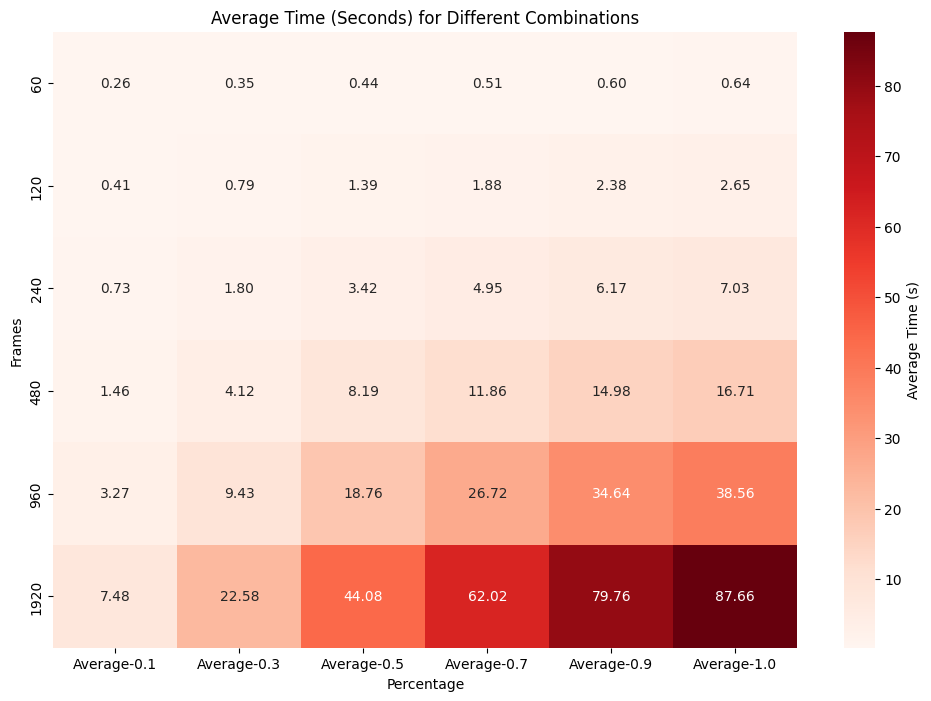

In [116]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

In [77]:
avg_data

{(60, 0.1): 0.2624218463897705,
 (60, 0.3): 0.3515271345774333,
 (60, 0.5): 0.4365028540293376,
 (60, 0.7): 0.5107277234395345,
 (60, 0.9): 0.5986191431681315,
 (60, 1): 0.6381227970123291,
 (120, 0.1): 0.4144340356190999,
 (120, 0.3): 0.7858752409617106,
 (120, 0.5): 1.3947783311208088,
 (120, 0.7): 1.8787000974019368,
 (120, 0.9): 2.3838938077290854,
 (120, 1): 2.6524309317270913,
 (240, 0.1): 0.7270742257436117,
 (240, 0.3): 1.8023349444071453,
 (240, 0.5): 3.4199750423431396,
 (240, 0.7): 4.948466142018636,
 (240, 0.9): 6.165395736694336,
 (240, 1): 7.029302358627319,
 (480, 0.1): 1.4633424282073975,
 (480, 0.3): 4.1171793937683105,
 (480, 0.5): 8.190629323323568,
 (480, 0.7): 11.8599960009257,
 (480, 0.9): 14.982348124186197,
 (480, 1): 16.710698286692303,
 (960, 0.1): 3.272573391596476,
 (960, 0.3): 9.427900791168213,
 (960, 0.5): 18.759346961975098,
 (960, 0.7): 26.71850307782491,
 (960, 0.9): 34.64037426312765,
 (960, 1): 38.55591789881388,
 (1920, 0.1): 7.482625166575114,
 (19

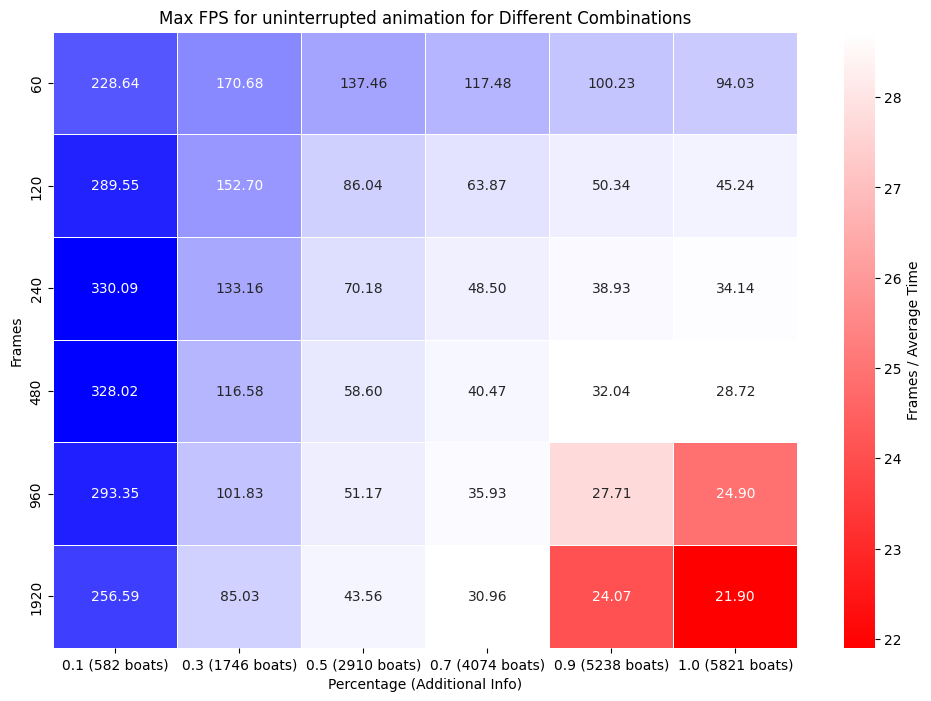

In [118]:
fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "white"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["white", "blue"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_above_30, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

In [100]:
def get_folder_size_mb(dir_name):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)
    # Convert size to MB
    total_size_mb = total_size / (1024 * 1024)
    return total_size_mb

In [104]:
memory_used = {}
for combination in times.keys():
    dir_name = f"/home/ali/matrices/{combination[0]}_{combination[1]}"
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
memory_used

{(60, 0.1): 2.1064624786376953,
 (60, 0.3): 6.321917533874512,
 (60, 0.5): 10.548554420471191,
 (60, 0.7): 14.773876190185547,
 (60, 0.9): 18.99924087524414,
 (60, 1): 21.119027137756348,
 (120, 0.1): 4.822900772094727,
 (120, 0.3): 14.484847068786621,
 (120, 0.5): 24.85445785522461,
 (120, 0.7): 35.127076148986816,
 (120, 0.9): 45.41509437561035,
 (120, 1): 50.764564514160156,
 (240, 0.1): 10.695036888122559,
 (240, 0.3): 32.140074729919434,
 (240, 0.5): 56.05718231201172,
 (240, 0.7): 79.36045837402344,
 (240, 0.9): 102.70853424072266,
 (240, 1): 114.8800573348999,
 (480, 0.1): 23.31965160369873,
 (480, 0.3): 70.12192821502686,
 (480, 0.5): 123.53309440612793,
 (480, 0.7): 174.7602310180664,
 (480, 0.9): 225.8536605834961,
 (480, 1): 252.39482402801514,
 (960, 0.1): 50.73875713348389,
 (960, 0.3): 152.21031951904297,
 (960, 0.5): 270.05585765838623,
 (960, 0.7): 381.6549005508423,
 (960, 0.9): 492.5690288543701,
 (960, 1): 549.0590782165527,
 (1920, 0.1): 107.92498970031738,
 (1920, 

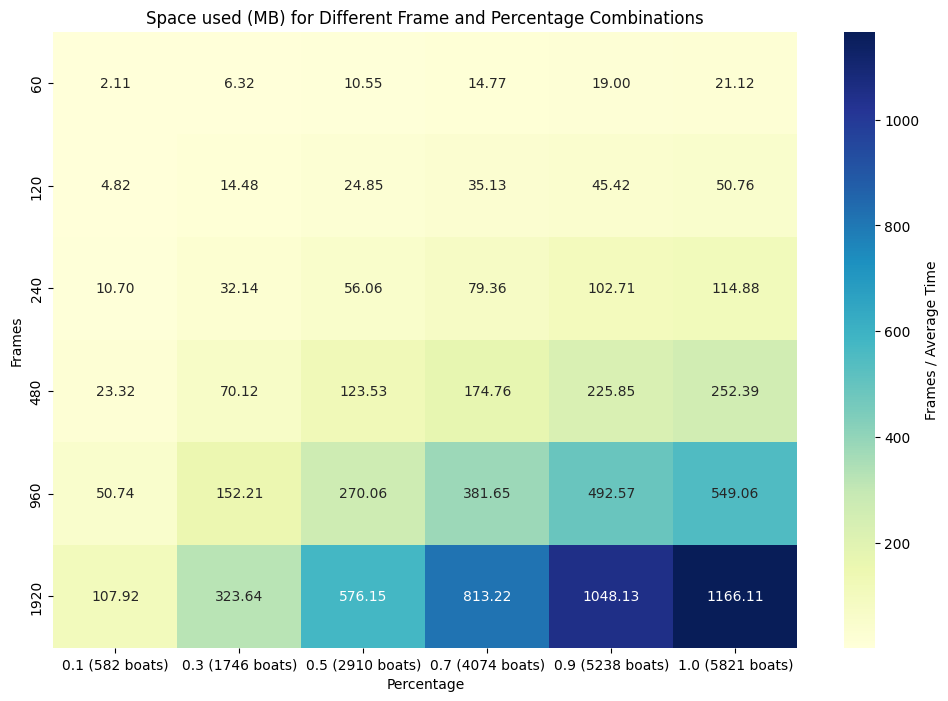

In [108]:


df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

In [33]:
number_of_objects

{0.1: 582, 0.3: 1746, 0.5: 2910, 0.7: 4074, 0.9: 5238, 1: 5821}

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary with additional column information
column_info = {0.1: 582, 0.3: 1746, 0.5: 2910, 0.7: 4074, 0.9: 5238, 1: 5821}

# Updated dictionary for memory used (mock data for demonstration)
memory_used = {
    (60, 0.1): 10, (60, 0.3): 20, (60, 0.5): 30, (60, 0.7): 40, (60, 0.9): 50, (60, 1): 60,
    (120, 0.1): 15, (120, 0.3): 25, (120, 0.5): 35, (120, 0.7): 45, (120, 0.9): 55, (120, 1): 65,
    (240, 0.1): 20, (240, 0.3): 30, (240, 0.5): 40, (240, 0.7): 50, (240, 0.9): 60, (240, 1): 70,
    (480, 0.1): 25, (480, 0.3): 35, (480, 0.5): 45, (480, 0.7): 55, (480, 0.9): 65, (480, 1): 75,
    (960, 0.1): 30, (960, 0.3): 40, (960, 0.5): 50, (960, 0.7): 60, (960, 0.9): 70, (960, 1): 80,
    (1920, 0.1): 35, (1920, 0.3): 45, (1920, 0.5): 55, (1920, 0.7): 65, (1920, 0.9): 75, (1920, 1): 85
}

# Create DataFrame
df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['Memory_Used_MB'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

# Unstack the DataFrame for heatmap plotting
df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)

# Update the column names with the additional info
df_frames_per_value_unstacked.columns = [f"{col} ({column_info[col]} units)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Memory Used (MB)'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()
